In [ ]:
!pip install numdifftools matplotlib --upgrade

## Dataset and useful functions

In [2]:
from matplotlib import pyplot as plt
from sklearn import datasets
import numdifftools as nd
import numpy as np
import random
from IPython.display import clear_output

In [3]:
l2norm = lambda x: sum([i**2 for i in x])

normalize = lambda x, norm : x/norm(x)

def sign(x):
    if x>0:
        return 1
    elif x<0:
        return -1
    else:
        return 0

# input two numpy vectors
def linfun(w, x):
    return 1 if np.inner(w,x) > 0 else -1

# input a 2D vector to get the perpendicular to 
def prp2D(X):
    if X[0] != 0:
      temp = [-1*X[1]/X[0] , 1]
    else:
      temp = [1 , -1*X[0]/X[1]]
    return temp


X, y = datasets.make_blobs(n_samples=10500,n_features=2,
                           centers=2,cluster_std=1.05,
                           random_state=2)
model_data = [(X[i], y[i]) for i in range(len(X))]

## Parent class of linear learning models

In [7]:
class linModel():
  def __init__(self, data, norm):
      self.data = data
      self.dataX = np.array([x for x, y in self.data])
      self.datay = np.array([y for x, y in self.data])
      self.dimension = len(self.data[0][0])
      self.datalen = len(self.data)
      self.norm = norm
      self.w = np.array([0 for _ in range(self.dimension)])
      self.b = np.array([0 for _ in range(self.dimension)])
      self.wprp = None
      self.plot_auto_update = False
      self.iteration = 0
      self.itermax = 5*len(self.dataX)
        
  def display(self):
      fig, alt = plt.subplots(figsize=(6.4*1, 4.8*1))
      plt.scatter(self.dataX[:, 0], self.dataX[:, 1], marker="o", c=self.datay)
      plt.xlabel("feature 1")
      plt.ylabel("feature 2")
      plt.title('Random Classification Data with 2 classes')
      if self.dimension == 2:
        self.wprp = prp2D(self.w)
        self.slope = (self.wprp[1] - self.b[1])/(self.wprp[0] - self.b[0])
        plt.axline((0,0), slope=self.slope, color='green')
      plt.quiver([0], [0], self.w[0], self.w[1], color = 'black') # plot the normal to the hyperplane vector
      ymin = np.amin(self.dataX[:, 1])
      ymax = np.amax(self.dataX[:, 1])
      #ax.set_ylim([ymin - 3, ymax + 3])
      plt.show()

  def predict(self, X):
    return np.array([sign(np.matmul(self.w.transpose(), i)) for i in X])

## Perceptron

In [8]:
class Perceptron(linModel):

    def objfunc(self, x):
      return 1 if np.inner(self.w, x) > 0 else -1

    def auto_update_plot(self):
        if not self.plot_auto_update:
            auto_update = input(f"Iteration @ {self.iteration} Auto Update? (y/n):")
            if auto_update == 'y':
                self.plot_auto_update = True
            else:
                clear_output(wait=True)
        else:
            clear_output(wait=True)
    
    def fit(self):
        self.iteration = 0
        while True:
            solved = True
            # self.display()
            # self.auto_update_plot()
            x, y = random.choice(self.data)
            h = self.objfunc(x) # this will be '1' or '-1'
            if not ((y == h) or (y == 0 and h == -1)): # because when y = 0 and h = -1 it means the same thing
                t = -1 if y == 0 else 1
                self.w = self.w + t*x
                self.iteration += 1
                solved = False
            else:
                # Check if the model is solved
                for x, y in self.data:
                    h = self.objfunc(x) # this will be '1' or '-1'
                    if not ((h == y) or (h == -1 and y == 0)):
                        solved = False
                        break
            if solved or self.iteration > self.itermax:
                break

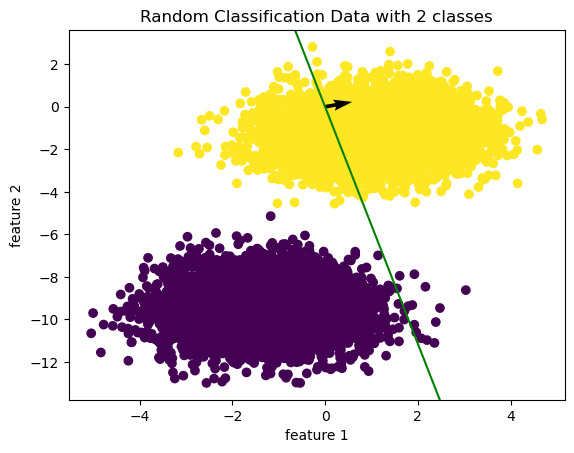

In [9]:
percep_model = Perceptron(model_data, l2norm)
percep_model.fit()
percep_model.display()

In [10]:
percep_model.iteration

52501

## Linear Regression (Closed form)
The closed form solution for the classification problem with linear regression fails spectacularly on datasets like above because we assume the value **w** $\cdot$ **x** will be equal to **y**, but in discrete classification problems since the function $f:$ **x** $\to$ **w** $\cdot$ **x** is continuous, even for linearly seperable datasets the ideal **w\*** $\cdot$ **x** will atmost take the sign of **y** and not necessarily the value of **y**

Therefore for linearly seperable cases what one must use is

**w\*** = arg(**w**) min $\sum$ |sign(**w** $\cdot$ **x**) - y |

In [11]:
## 1st question
class linRegression(linModel):

  def fit(self):
    X = self.dataX
    Y = self.datay.transpose()
    self.w = np.matmul(np.linalg.inv(np.matmul(X.transpose(), X)), np.matmul(X.transpose(), Y))

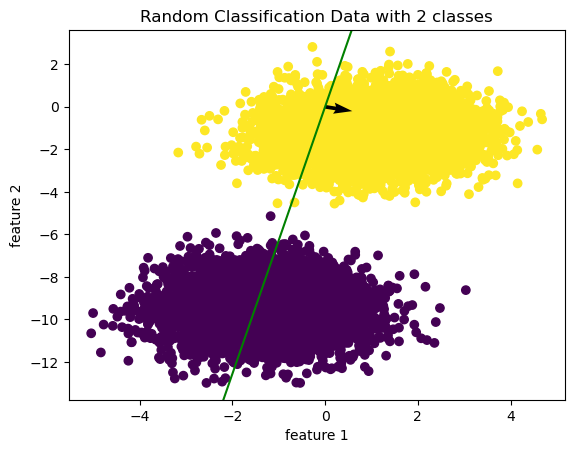

In [12]:
linmodel = linRegression(model_data, l2norm)
linmodel.fit()
linmodel.display()

In [13]:
linmodel.w

array([ 0.31541411, -0.05019439])

## Gradient Descent

`def grad_desc(func, start, step, norm=l2norm, itermax = 10**8, errormax=10**(-10), grad_func=None)`

In [14]:
''' 
  Constant Step size Gradient Descent algorithm
'''

def grad_desc(func, start, step=0.005, norm=l2norm, itermax = 10**8, errormax=10**(-10), grad_func=None):
  init = np.array(start)
  for _ in range(itermax):
    grad = np.array(nd.Gradient(func)([init])) if grad_func is None else grad_func(init)
    Xn = init - step*grad
    if norm(Xn - init) < errormax*step: # because the difference in the valeus is also depending on the step-size
      return Xn
    init = Xn
  return init

In [15]:
l2 = lambda x : x[0]**2 + x[1]**2
grad_desc(l2, [4,4], 0.005)

array([4.91647589e-05, 4.91647589e-05])

## Minimum Classification Error

In [16]:
class MCE(linModel):

  @staticmethod
  def sigmoid(x):
    return 1/(1 + np.exp(-1*x))

  def objfunc(self, w):
    out = 0
    for i in range(self.datalen):
      out +=  self.sigmoid(-1*self.datay[i]*np.matmul(w, self.dataX[i]))
    return out

  def obj_grad(self, w):
    out = 0
    for i in range(self.datalen):
      temp = self.sigmoid(self.datay[i]*np.matmul(w, self.dataX[i]))
      out +=  self.datay[i]*temp*(1-temp)*self.dataX[i]
    return out
  
  def fit(self):
    self.w = -1*grad_desc(self.objfunc, self.w, step=0.05, norm=l2norm, itermax=10**4, errormax=10**(-4), grad_func=self.obj_grad)

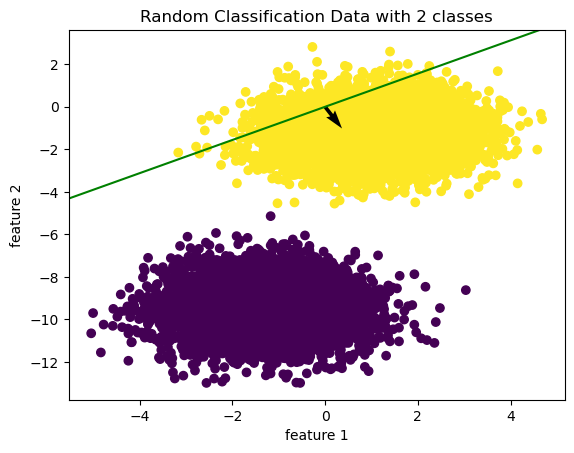

In [17]:
mce_model = MCE(model_data, l2norm)
mce_model.fit()
mce_model.display()

## Logistic Regression

In [18]:
class logRegression(linModel):
  @staticmethod
  def sigmoid(x):
    return 1/(1 + np.exp(-1*x))

  def objfunc(self, w):
    out = 0
    for i in range(self.datalen):
      out +=  np.log(self.sigmoid(self.datay[i]*np.matmul(w, self.dataX[i])))
    return out

  def obj_grad(self, w):
    out = 0
    for i in range(self.datalen):
      out +=  self.datay[i]*(1-self.sigmoid(self.datay[i]*np.matmul(w, self.dataX[i])))*self.dataX[i]
    return out
  
  def fit(self):
    self.w = -1*grad_desc(self.objfunc, self.w, step=0.05, norm=l2norm, itermax=10**3, errormax=10**(-3), grad_func=self.obj_grad)

/tmp/ipykernel_3165/3191286250.py:4: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-1*x))


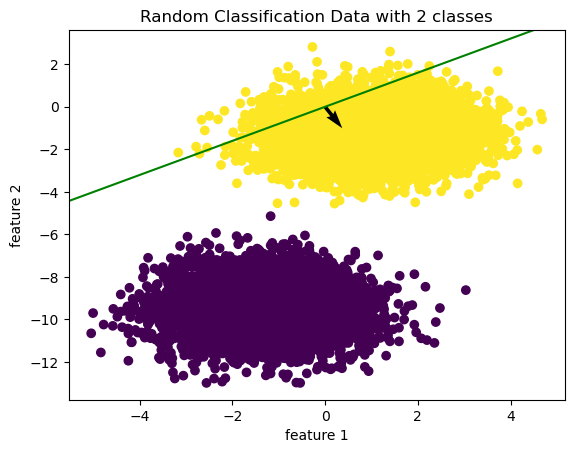

In [19]:
logR_model = logRegression(model_data, l2norm)
logR_model.fit()
logR_model.display()